In [1]:
import pandas as pd
import pyodbc
from contextlib import closing

# Connection parameters
server = 'OMARZPC'
database = 'DW_Price_comparator'
conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

tables = [
    'Fact_Hotels',
    'Dim_Travel_To_Do',
    'Dim_Touring',
    'Dim_Date',
    'dim_location',
    'Dim_Desc_hotels',
    'Dim_Booking',
]

dataframes = {}

try:
    with closing(pyodbc.connect(conn_str)) as conn:
        print("✅ Connection successful!")
        
        for table in tables:
            try:
                # Consider limiting columns for large tables: SELECT col1, col2 FROM...
                query = f"SELECT TOP 1000 * FROM [dbo].[{table}]"  # Added TOP for initial testing
                df = pd.read_sql(query, conn)
                dataframes[table.lower()] = df
                print(f"✅ Loaded {table} ({df.shape[0]} rows, {df.shape[1]} columns)")
                
                # Quick peek at the data
                print(df.head(2))
                print("\n" + "="*50 + "\n")
                
            except Exception as table_error:
                print(f"⚠️ Error loading {table}: {str(table_error)}")
                continue
                
    print("🔒 Connection closed automatically.")

except pyodbc.InterfaceError as e:
    print(f"❌ Connection Error: {e}")
except pyodbc.DatabaseError as e:
    print(f"❌ Database Error: {e}")
except Exception as e:
    print(f"❌ Unexpected Error: {e}")

✅ Connection successful!
✅ Loaded Fact_Hotels (1000 rows, 10 columns)
   Fk_Hotels FK_Hotel_desc  FK_CheckinDate  FK_CheckoutDate  FK_Location  \
0          1          None        20250311         20250312          201   
1          2          None        20250311         20250312          201   

                  Hotel_Name  Number_of_Stars  Old_Price  New_Price  \
0        Hotel Casa Gardenia                6       98.0       98.0   
1  Catalonia Sagrada Familia                4       76.0       76.0   

  Travel_Agency  
0       Booking  
1       Booking  


✅ Loaded Dim_Travel_To_Do (1000 rows, 3 columns)
   PK_Hotel                                          Name Currency
0         1                                 Joya Paradise       DT
1         2  Radisson Blu Palace Resort & Thalasso Djerba       DT


✅ Loaded Dim_Touring (1000 rows, 3 columns)
   PK_Hotel               Hotel_Name Currency
0         1  Grand Hotel Des Thermes       DT
1         2           Olympic Djerba       

C:\Users\omarh\AppData\Local\Temp\ipykernel_10752\1588324909.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\omarh\AppData\Local\Temp\ipykernel_10752\1588324909.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\omarh\AppData\Local\Temp\ipykernel_10752\1588324909.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\omarh\AppData\Local\Temp\ipykernel_10752\1588324909.py:30: UserWarning: pandas only supp

In [3]:
# Extract DataFrames from dictionary (ensure lowercase keys match)
fact_hotels = dataframes['fact_hotels']
date = dataframes['dim_date']
location = dataframes['dim_location']
desc_hotels = dataframes['dim_desc_hotels']  # Verify exact key name in dataframes

# 1️⃣ Type Conversion - Ensure merge keys have matching types
try:
    # Convert FK_Hotel_desc to match PK_Hotel's type (int)
    fact_hotels['FK_Hotel_desc'] = pd.to_numeric(fact_hotels['FK_Hotel_desc'], errors='raise')
    desc_hotels['PK_Hotel'] = desc_hotels['PK_Hotel'].astype(int)
    
    # Verify other foreign keys
    fact_hotels['FK_CheckinDate'] = pd.to_numeric(fact_hotels['FK_CheckinDate'], errors='raise')
    fact_hotels['FK_CheckoutDate'] = pd.to_numeric(fact_hotels['FK_CheckoutDate'], errors='raise')
    fact_hotels['FK_Location'] = pd.to_numeric(fact_hotels['FK_Location'], errors='raise')
    
except ValueError as e:
    print(f"❌ Type conversion error: {e}")
    # Show problematic values if conversion fails
    print("Problem values in FK_Hotel_desc:", 
          fact_hotels.loc[pd.to_numeric(fact_hotels['FK_Hotel_desc'], errors='coerce').isna()].head())

# 2️⃣ Perform all merges with validation
try:
    # 1. Merge with Dim_Date (Check-in)
    merged_df = fact_hotels.merge(
        date,
        left_on='FK_CheckinDate',
        right_on='PK_Date',
        how='left',
        suffixes=('', '_Checkin'),
        validate='m:1'
    )
    
    # 2. Merge with Dim_Date (Check-out)
    merged_df = merged_df.merge(
        date,
        left_on='FK_CheckoutDate',
        right_on='PK_Date',
        how='left',
        suffixes=('', '_Checkout'),
        validate='m:1'
    )
    
    # 3. Merge with Dim_Location
    merged_df = merged_df.merge(
        location,
        left_on='FK_Location',
        right_on='PK_Location',
        how='left',
        validate='m:1'
    )
    
    # 4. Merge with Dim_Desc_Hotels
    merged_df = merged_df.merge(
        desc_hotels,
        left_on='FK_Hotel_desc',
        right_on='PK_Hotel',
        how='left',
        validate='m:1'
    )
    
    print("✅ All merges completed successfully!")
    print(f"Final DataFrame shape: {merged_df.shape}")
    
    # Show merge validation
    print("\nMerge Summary:")
    print(f"- Rows in final output: {len(merged_df)}")
    print(f"- Original fact table rows: {len(fact_hotels)}")
    print(f"- Check-in date matches: {merged_df['PK_Date'].notna().sum()}")
    print(f"- Check-out date matches: {merged_df['PK_Date_Checkout'].notna().sum()}")
    print(f"- Location matches: {merged_df['PK_Location'].notna().sum()}")
    print(f"- Hotel description matches: {merged_df['PK_Hotel'].notna().sum()}")

except Exception as e:
    print(f"❌ Merge failed: {str(e)}")
    # Debugging info
    if 'merged_df' in locals():
        print("\nDebug Info (last successful merge):")
        print(merged_df.head(2))

✅ All merges completed successfully!
Final DataFrame shape: (1000, 45)

Merge Summary:
- Rows in final output: 1000
- Original fact table rows: 1000
- Check-in date matches: 0
- Check-out date matches: 0
- Location matches: 1000
- Hotel description matches: 0


In [5]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns  # Added for enhanced visualization
%matplotlib inline

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression  # Added common models
from sklearn.metrics import (accuracy_score, classification_report, 
                           mean_squared_error, silhouette_score,
                           confusion_matrix, roc_auc_score)  # Added more metrics
from sklearn.model_selection import (train_test_split, 
                                   GridSearchCV, 
                                   cross_val_score)  # Added model selection tools
from sklearn.preprocessing import (StandardScaler, 
                                 LabelEncoder, 
                                 OneHotEncoder,
                                 MinMaxScaler)  # Added more preprocessing
from sklearn.pipeline import make_pipeline  # Added for pipeline creation

# Time Series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Added for seasonal ARIMA


# Utilities
import warnings
from datetime import datetime  # Helpful for time series
import pickle  # For model serialization

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)  # Better DataFrame display
np.random.seed(42)  # For reproducibility

In [7]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc
import time


In [9]:
def charger_donnees_sql():
    """Connexion à la base SQL Server et chargement de la table Fact_Hotels"""
    server = 'OMARZPC'
    database = 'DW_Price_comparator'
    conn_str = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database};Trusted_Connection=yes;'

    try:
        conn = pyodbc.connect(conn_str)
        print("✅ Connexion SQL réussie.")
        query = "SELECT * FROM dbo.Fact_Hotels"
        hotels = pd.read_sql(query, conn)
        conn.close()
        print(f"✅ Données chargées : {hotels.shape[0]} lignes.")
        return hotels
    except Exception as e:
        print(f"❌ Erreur de connexion ou de requête SQL : {e}")
        return None


In [11]:
def preparer_donnees(hotels):
    features = ['New_Price', 'Old_Price']
    hotels = hotels.dropna(subset=features)
    data = hotels[features]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    return hotels, data, scaled_data


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def detecter_meilleur_k(scaled_data, k_min=2, k_max=10):
    silhouette_scores = []
    k_range = range(k_min, k_max + 1)

    print("\n🔎 Recherche du meilleur K pour KMeans...")

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        silhouette_scores.append(score)
        print(f"K={k} ➤ Silhouette Score = {score:.4f}")

    # Visualisation
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, silhouette_scores, marker='o', color='blue')
    plt.title("Silhouette Score en fonction de K (KMeans)")
    plt.xlabel("Nombre de clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.xticks(k_range)
    plt.tight_layout()
    plt.show()

    # Meilleur K = max silhouette
    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"\n✅ Meilleur K détecté : {best_k} (Silhouette Score = {max(silhouette_scores):.4f})")

    return best_k


In [15]:
def detecter_meilleur_k_agglomerative(scaled_data, k_min=2, k_max=10):
    silhouette_scores = []
    k_range = range(k_min, k_max + 1)

    print("\n🔎 Recherche du meilleur K pour Agglomerative...")

    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k)
        labels = agg.fit_predict(scaled_data)
        score = silhouette_score(scaled_data, labels)
        silhouette_scores.append(score)
        print(f"K={k} ➤ Silhouette Score = {score:.4f}")

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, silhouette_scores, marker='o', color='green')
    plt.title("Silhouette Score en fonction de K (Agglomerative)")
    plt.xlabel("Nombre de clusters (K)")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.xticks(k_range)
    plt.tight_layout()
    plt.show()

    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"\n✅ Meilleur K détecté pour Agglomerative : {best_k} (Silhouette Score = {max(silhouette_scores):.4f})")

    return best_k


In [35]:
from sklearn.metrics import silhouette_score
import numpy as np

def detecter_meilleurs_params_dbscan(scaled_data, eps_values=[0.3, 0.5, 0.7, 1.0], min_samples_values=[3, 5, 10]):
    print("\n🔎 Optimisation de DBSCAN...")

    meilleurs_params = None
    meilleur_score = -1
    meilleurs_labels = None

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(scaled_data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters >= 2:
                try:
                    score = silhouette_score(scaled_data, labels)
                    print(f"eps={eps}, min_samples={min_samples} ➤ silhouette = {score:.4f}, clusters = {n_clusters}")
                    if score > meilleur_score:
                        meilleur_score = score
                        meilleurs_params = (eps, min_samples)
                        meilleurs_labels = labels
                except:
                    continue

    if meilleurs_params:
        print(f"\n✅ Meilleurs paramètres DBSCAN : eps={meilleurs_params[0]}, min_samples={meilleurs_params[1]} (Silhouette = {meilleur_score:.4f})")
        return meilleurs_params
    else:
        print("❌ Aucun paramètre DBSCAN valide trouvé.")
        return None


In [37]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


In [39]:
def appliquer_clustering_avec_scores(hotels, scaled_data, best_k_kmeans, best_k_agg):
    results = {}

    # === KMeans ===
    print("▶️ KMeans...")
    kmeans = KMeans(n_clusters=best_k_kmeans, random_state=42)
    kmeans_labels = kmeans.fit_predict(scaled_data)
    hotels['KMeans_Cluster'] = kmeans_labels
    results['KMeans'] = {
        'labels': kmeans_labels,
        'silhouette': silhouette_score(scaled_data, kmeans_labels),
        'davies_bouldin': davies_bouldin_score(scaled_data, kmeans_labels),
        'calinski_harabasz': calinski_harabasz_score(scaled_data, kmeans_labels)
    }

     # === DBSCAN (avec meilleurs paramètres détectés) ===
    print("▶️ DBSCAN...")
    dbscan_params = detecter_meilleurs_params_dbscan(scaled_data)

    if dbscan_params:
        eps, min_samples = dbscan_params
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(scaled_data)
        hotels['DBSCAN_Cluster'] = dbscan_labels

        results['DBSCAN'] = {
            'labels': dbscan_labels,
            'silhouette': silhouette_score(scaled_data, dbscan_labels),
            'davies_bouldin': davies_bouldin_score(scaled_data, dbscan_labels),
            'calinski_harabasz': calinski_harabasz_score(scaled_data, dbscan_labels)
        }
    else:
        hotels['DBSCAN_Cluster'] = [-1] * len(scaled_data)  # tout bruit
        results['DBSCAN'] = {
            'labels': None,
            'silhouette': 'Non calculable',
            'davies_bouldin': 'Non calculable',
            'calinski_harabasz': 'Non calculable'
        }

    # === Agglomerative ===
    print("▶️ Agglomerative...")
    agg = AgglomerativeClustering(n_clusters=best_k_agg)
    agg_labels = agg.fit_predict(scaled_data)
    hotels['Agglomerative_Cluster'] = agg_labels
    results['Agglomerative'] = {
        'labels': agg_labels,
        'silhouette': silhouette_score(scaled_data, agg_labels),
        'davies_bouldin': davies_bouldin_score(scaled_data, agg_labels),
        'calinski_harabasz': calinski_harabasz_score(scaled_data, agg_labels)
    }

    return hotels, results


In [41]:
def afficher_scores(results):
    print("\n📊 COMPARAISON DES SCORES")
    for model, scores in results.items():
        print(f"\n📌 {model}:")
        for metric, value in scores.items():
            if metric != 'labels':
                print(f"  - {metric}: {value}")


In [43]:
import matplotlib.pyplot as plt

def visualiser_clusters(hotels, data):
    plt.figure(figsize=(12, 4))

    # KMeans
    plt.subplot(1, 3, 1)
    plt.scatter(data['New_Price'], data['Old_Price'], c=hotels['KMeans_Cluster'], cmap='viridis', alpha=0.6)
    plt.title('KMeans Clustering')
    plt.xlabel('Nouveau Prix (€)')
    plt.ylabel('Ancien Prix (€)')

    # DBSCAN
    plt.subplot(1, 3, 2)
    plt.scatter(data['New_Price'], data['Old_Price'], c=hotels['DBSCAN_Cluster'], cmap='viridis', alpha=0.6)
    plt.title('DBSCAN Clustering')

    # Agglomerative
    plt.subplot(1, 3, 3)
    plt.scatter(data['New_Price'], data['Old_Price'], c=hotels['Agglomerative_Cluster'], cmap='viridis', alpha=0.6)
    plt.title('Agglomerative Clustering')

    plt.tight_layout()
    plt.show()
 

=== DÉBUT DU CLUSTERING COMPARATIF ===
✅ Connexion SQL réussie.
✅ Données chargées : 81512 lignes.

🔎 Recherche du meilleur K pour KMeans...
K=2 ➤ Silhouette Score = 0.6782
K=3 ➤ Silhouette Score = 0.6019
K=4 ➤ Silhouette Score = 0.6159
K=5 ➤ Silhouette Score = 0.5735
K=6 ➤ Silhouette Score = 0.5720
K=7 ➤ Silhouette Score = 0.5735
K=8 ➤ Silhouette Score = 0.5543
K=9 ➤ Silhouette Score = 0.5523
K=10 ➤ Silhouette Score = 0.5474


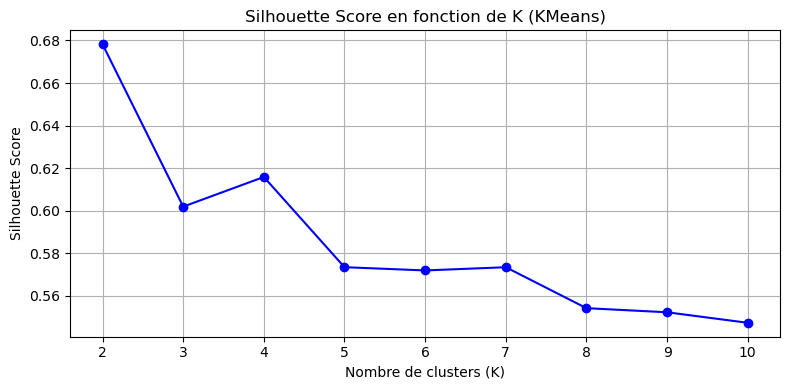


✅ Meilleur K détecté : 2 (Silhouette Score = 0.6782)

🔎 Recherche du meilleur K pour Agglomerative...
K=2 ➤ Silhouette Score = 0.6769
K=3 ➤ Silhouette Score = 0.5597
K=4 ➤ Silhouette Score = 0.6006
K=5 ➤ Silhouette Score = 0.5633
K=6 ➤ Silhouette Score = 0.5653
K=7 ➤ Silhouette Score = 0.5532
K=8 ➤ Silhouette Score = 0.5599
K=9 ➤ Silhouette Score = 0.5610
K=10 ➤ Silhouette Score = 0.5433


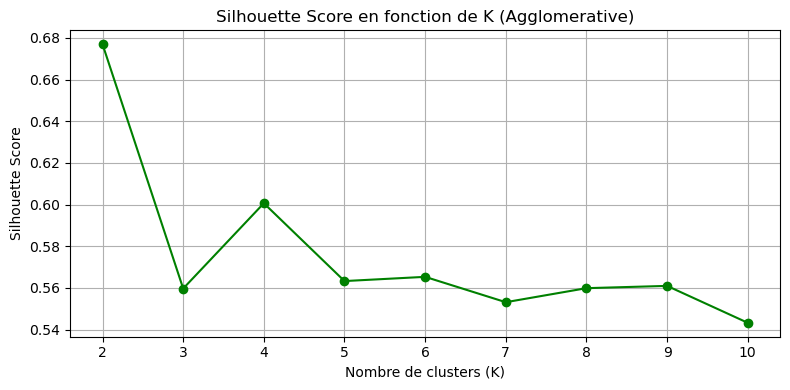


✅ Meilleur K détecté pour Agglomerative : 2 (Silhouette Score = 0.6769)
▶️ KMeans...
▶️ DBSCAN...

🔎 Optimisation de DBSCAN...
eps=0.3, min_samples=3 ➤ silhouette = 0.1564, clusters = 3
eps=0.3, min_samples=5 ➤ silhouette = 0.4315, clusters = 2
eps=0.3, min_samples=10 ➤ silhouette = 0.4611, clusters = 2

✅ Meilleurs paramètres DBSCAN : eps=0.3, min_samples=10 (Silhouette = 0.4611)
▶️ Agglomerative...

📊 COMPARAISON DES SCORES

📌 KMeans:
  - silhouette: 0.678220372638058
  - davies_bouldin: 0.4955564421560782
  - calinski_harabasz: 2410.074931366347

📌 DBSCAN:
  - silhouette: 0.4611454676539959
  - davies_bouldin: 0.7367138801827134
  - calinski_harabasz: 336.162671411302

📌 Agglomerative:
  - silhouette: 0.6769194228401777
  - davies_bouldin: 0.49800034711495483
  - calinski_harabasz: 2409.262524607788


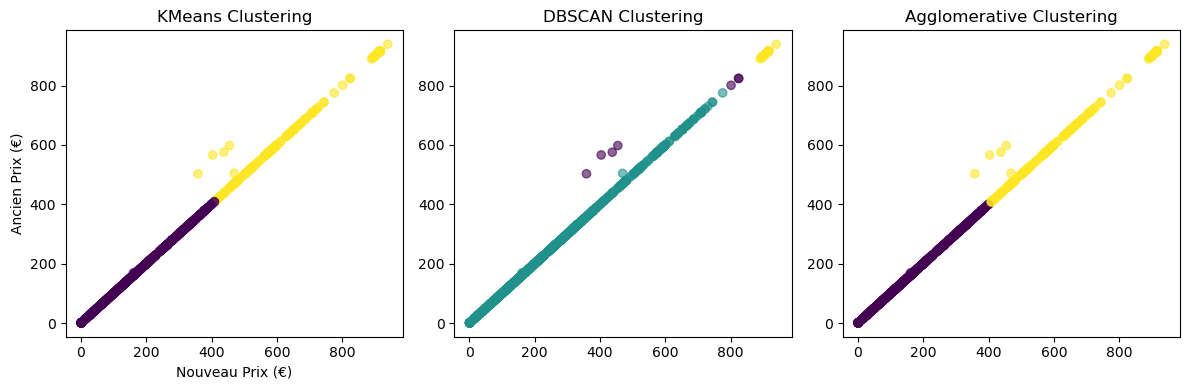

In [45]:
print("=== DÉBUT DU CLUSTERING COMPARATIF ===")
hotels = charger_donnees_sql()

if hotels is not None:
    hotels = hotels.sample(n=1000, random_state=42)
    hotels, data, scaled_data = preparer_donnees(hotels)

    best_k_kmeans = detecter_meilleur_k(scaled_data)
    best_k_agg = detecter_meilleur_k_agglomerative(scaled_data)

    hotels, results = appliquer_clustering_avec_scores(hotels, scaled_data, best_k_kmeans, best_k_agg)
    afficher_scores(results)
    visualiser_clusters(hotels, data)
else:
    print("❌ Échec de chargement des données.")


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd


In [43]:
def price_drop_classification(hotels):
    """Prédiction des bonnes affaires avec différents algorithmes de classification"""

    print("\n=== 2. CLASSIFICATION: BONNES AFFAIRES ===")

    # Création de la variable cible
    hotels = hotels.copy()
    hotels['Good_Deal'] = ((hotels['Old_Price'] - hotels['New_Price']) / hotels['Old_Price'] > 0.15).astype(int)

    # Vérifier la colonne 'Location_Encoded'
    if 'Location_Encoded' not in hotels.columns:
        print("⚠️ La colonne 'Location_Encoded' est manquante. Veuillez encoder les localisations d'abord.")
        return None

    # Préparation des features
    X = hotels[['Old_Price', 'Location_Encoded']]
    y = hotels['Good_Deal']

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèles
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Support Vector Machine': SVC(random_state=42)
    }

    for model_name, model in models.items():
        print(f"\n📊 Évaluation de {model_name} :")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"🔍 Rapport de classification pour {model_name} :\n")
        print(classification_report(y_test, y_pred))

        # Importance des variables (uniquement pour Random Forest)
        if model_name == 'Random Forest':
            feat_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
            feat_importance.plot(kind='barh')
            plt.title(f'Importance des Variables - {model_name}')
            plt.xlabel('Importance')
            plt.show() 


In [45]:
location_col = next((col for col in hotels.columns if 'location' in col.lower()), None)

if location_col:
    hotels['Location_Encoded'] = hotels[location_col].astype('category').cat.codes
    print(f"✅ Encodage effectué à partir de la colonne '{location_col}'")
else:
    print("❌ Aucune colonne correspondant à une localisation trouvée.")


✅ Encodage effectué à partir de la colonne 'FK_Location'



=== 2. CLASSIFICATION: BONNES AFFAIRES ===

📊 Évaluation de Random Forest :
🔍 Rapport de classification pour Random Forest :

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16171
           1       0.95      0.84      0.89       105

    accuracy                           1.00     16276
   macro avg       0.97      0.92      0.94     16276
weighted avg       1.00      1.00      1.00     16276



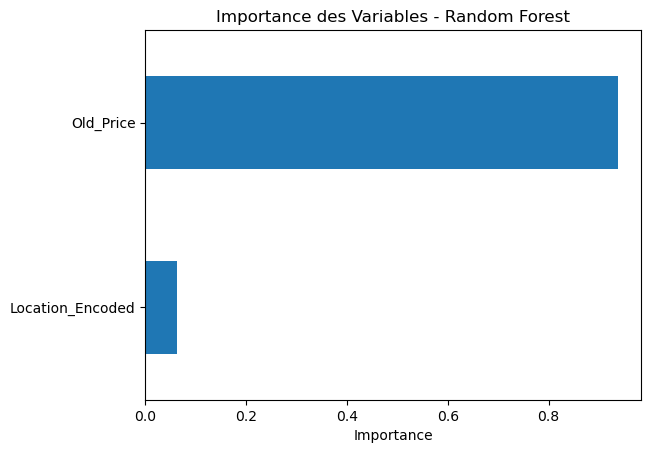


📊 Évaluation de Logistic Regression :
🔍 Rapport de classification pour Logistic Regression :

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16171
           1       0.00      0.00      0.00       105

    accuracy                           0.99     16276
   macro avg       0.50      0.50      0.50     16276
weighted avg       0.99      0.99      0.99     16276


📊 Évaluation de Support Vector Machine :
🔍 Rapport de classification pour Support Vector Machine :

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     16171
           1       0.00      0.00      0.00       105

    accuracy                           0.99     16276
   macro avg       0.50      0.50      0.50     16276
weighted avg       0.99      0.99      0.99     16276



In [47]:
classified_hotels = price_drop_classification(hotels)


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def price_regression(hotels):
    """Prédiction des nouveaux prix avec différents algorithmes de régression"""

    print("\n=== 3. RÉGRESSION: PRÉDICTION DE PRIX ===")

    # Préparation des données
    X = hotels[['Old_Price', 'Location_Encoded']]
    y = hotels['New_Price']

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modèles
    models = {
        'Random Forest Regressor': RandomForestRegressor(random_state=42),
        'Linear Regression': LinearRegression(),
        'Support Vector Regressor': SVR()
    }

    for model_name, model in models.items():
        print(f"\nÉvaluation de {model_name} :")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE pour {model_name}: {rmse:.2f}")

        # Visualisation des résultats
        plt.figure(figsize=(10,6))
        plt.scatter(y_test, y_pred, alpha=0.3)
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        plt.xlabel('Prix Réels')
        plt.ylabel('Prix Prédits')
        plt.title(f'Comparaison Prix Réels vs Prédictions - {model_name}')
        plt.grid(True)
        plt.show()



=== 3. RÉGRESSION: PRÉDICTION DE PRIX ===

Évaluation de Random Forest Regressor :
RMSE pour Random Forest Regressor: 9.86


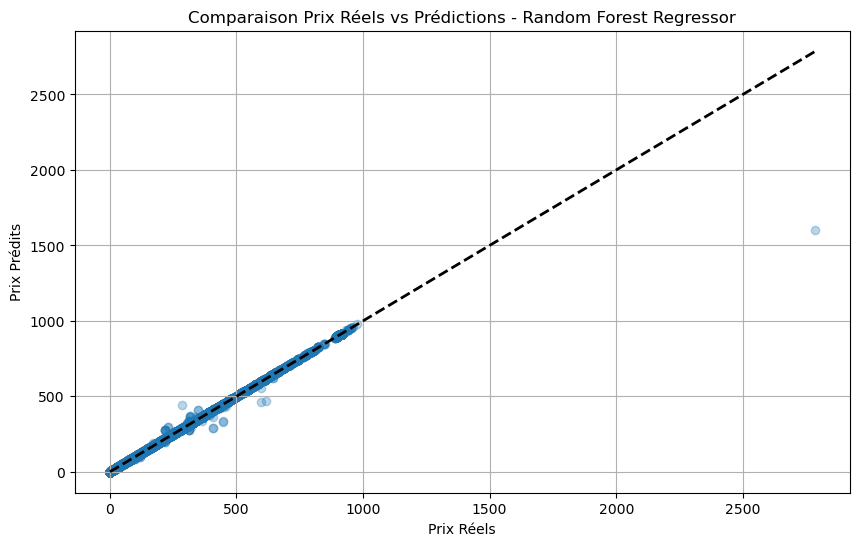


Évaluation de Linear Regression :
RMSE pour Linear Regression: 8.93


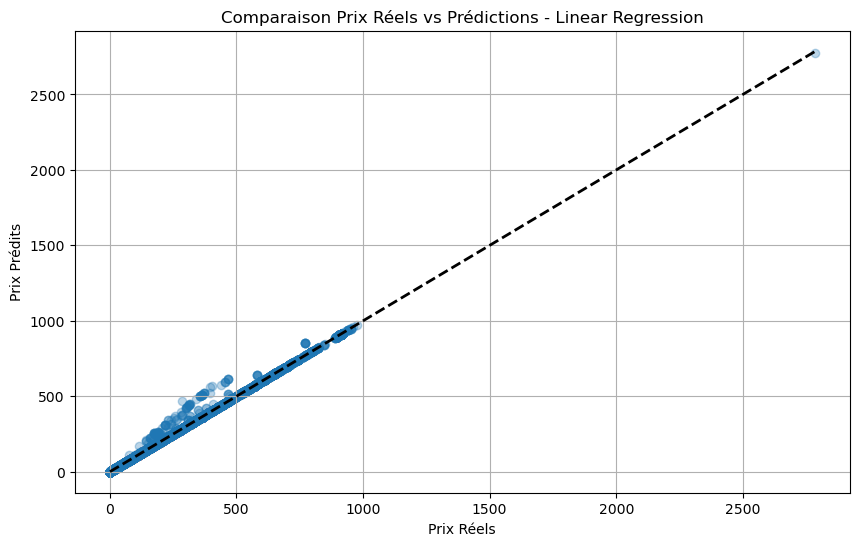


Évaluation de Support Vector Regressor :
RMSE pour Support Vector Regressor: 20.49


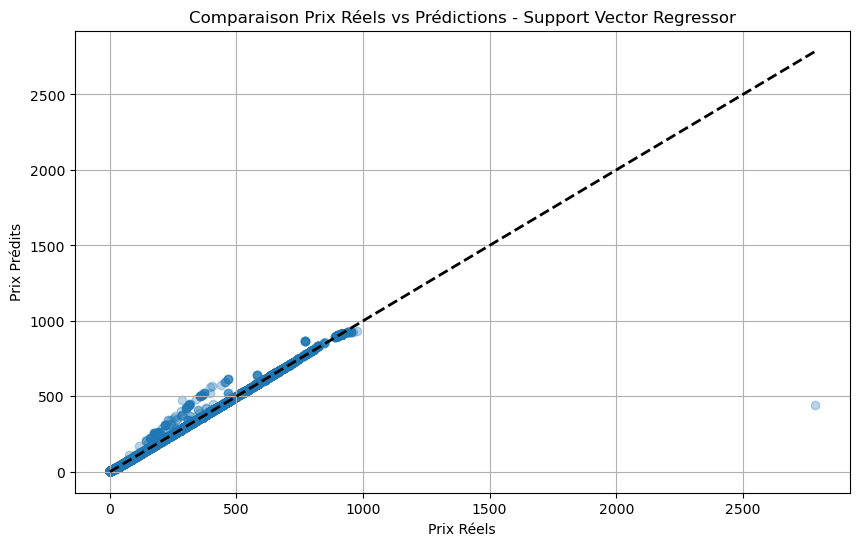

In [51]:
# Assure-toi que 'Location_Encoded' existe, sinon encode-la
if 'Location_Encoded' not in hotels.columns:
    location_col = next((col for col in hotels.columns if 'location' in col.lower()), None)
    if location_col:
        hotels['Location_Encoded'] = hotels[location_col].astype('category').cat.codes
        print(f"✅ Colonne 'Location_Encoded' créée à partir de '{location_col}'")
    else:
        print("❌ Colonne de localisation non trouvée.")

# Exécution de la régression
score_final = price_regression(hotels)


In [47]:
pip install pmdarima


  Using cached Cython-3.0.12-cp312-cp312-win_amd64.whl.metadata (3.6 kB)
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------------------------------- 625.1/625.1 kB 1.3 MB/s eta 0:00:00
Using cached Cython-3.0.12-cp312-cp312-win_amd64.whl (2.8 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [51]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd

def price_time_series(hotels):
    print("\n=== 4. SÉRIE TEMPORELLE ===")

    # Forcer le parsing correct si la colonne est en format entier (ex: 20250110)
    hotels['FK_CheckinDate'] = pd.to_datetime(hotels['FK_CheckinDate'], format='%Y%m%d')

    # Choisir la destination principale
    main_dest = hotels['FK_Location'].value_counts().index[0]
    print(f"\n📍 Analyse pour la destination : {main_dest}")

    # Préparer la série temporelle
    ts_data = hotels[hotels['FK_Location'] == main_dest]
    ts_data = ts_data.groupby('FK_CheckinDate')['New_Price'].mean().sort_index()

    # Décomposition saisonnière
    try:
        decomposition = seasonal_decompose(ts_data, model='additive', period=30)
        decomposition.plot()
        plt.suptitle(f'Décomposition Saisonnière - {main_dest}')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Erreur de décomposition : {e}")

    return ts_data, main_dest


In [64]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pmdarima import auto_arima

def forecast_models(ts_data, main_dest, forecast_days=90):
    print("\n=== 2. PRÉVISION DES PRIX ===")

    ts_data.index = pd.to_datetime(ts_data.index)

    if len(ts_data) < 30:
        print("⚠️ Données insuffisantes pour une prévision fiable.")
        return

    # ▶️ Auto-ARIMA pour déterminer les meilleurs paramètres
    print("🔍 Recherche des meilleurs paramètres avec auto_arima...")
    auto_model = auto_arima(
        ts_data,
        seasonal=True,
        m=12,                     # Période saisonnière (mensuelle)
        start_p=1, max_p=5,
        start_q=0, max_q=5,
        start_P=0, max_P=2,
        start_Q=0, max_Q=2,
        d=1,                  # Laisse auto_arima déterminer d
        D=1,                  # Laisse auto_arima déterminer D
        trace=True,
        stepwise=False,          # Teste plus de combinaisons
        error_action='ignore',
        suppress_warnings=True,
        approximation=False,
        max_order=10
    )
    
    arima_order = auto_model.order
    seasonal_order = auto_model.seasonal_order

    print(f"✅ Paramètres ARIMA détectés : {arima_order}")
    print(f"✅ Paramètres SARIMA saisonniers détectés : {seasonal_order}")

    # ▶️ Modèle ARIMA
    print(f"▶️ Modèle ARIMA {arima_order}")
    arima_model = ARIMA(ts_data, order=arima_order)
    arima_fit = arima_model.fit()
    forecast_arima = arima_fit.forecast(steps=forecast_days)

    # ▶️ Modèle SARIMA
    print(f"▶️ Modèle SARIMA {arima_order} + {seasonal_order}")
    sarima_model = SARIMAX(ts_data, order=arima_order, seasonal_order=seasonal_order)
    sarima_fit = sarima_model.fit()
    forecast_sarima = sarima_fit.forecast(steps=forecast_days)

    # 🔢 Créer les vraies dates de prévision
    forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=forecast_days)
    forecast_arima.index = forecast_dates
    forecast_sarima.index = forecast_dates

    # 📊 Affichage graphique
    plt.figure(figsize=(14, 5))
    plt.plot(ts_data.index, ts_data, label='Historique', color='black')
    plt.plot(forecast_arima.index, forecast_arima, 'r--', label='Prévision ARIMA')
    plt.plot(forecast_sarima.index, forecast_sarima, 'g--', label='Prévision SARIMA')

    plt.title(f'Prévision des Prix Moyens - {main_dest}')
    plt.xlabel('Date')
    plt.ylabel('Prix (€)')
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 🎯 Scores de performance sur les derniers jours
    print("\n=== 3. SCORES DE PERFORMANCE ===")
    test_size = min(forecast_days, int(len(ts_data) * 0.2))
    train = ts_data[:-test_size]
    test = ts_data[-test_size:]

    pred_arima = ARIMA(train, order=arima_order).fit().forecast(steps=test_size)
    pred_sarima = SARIMAX(train, order=arima_order, seasonal_order=seasonal_order).fit().forecast(steps=test_size)

    def score_model(y_true, y_pred, name):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        print(f"📌 {name} ➤ MAE: {mae:.2f} | RMSE: {rmse:.2f}")
        return mae, rmse

    score_model(test, pred_arima, "ARIMA")
    score_model(test, pred_sarima, "SARIMA")



=== 4. SÉRIE TEMPORELLE ===

📍 Analyse pour la destination : 258


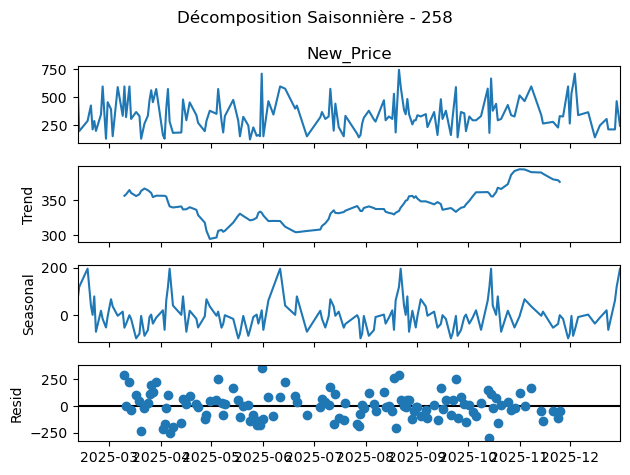


=== 2. PRÉVISION DES PRIX ===
🔍 Recherche des meilleurs paramètres avec auto_arima...
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1985.691, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=2.52 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1946.277, Time=0.22 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=4.76 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1941.751, Time=0.67 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=2.13 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=5.71 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.95 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=2.84 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(0,1,1)(1,1,2)[12]      

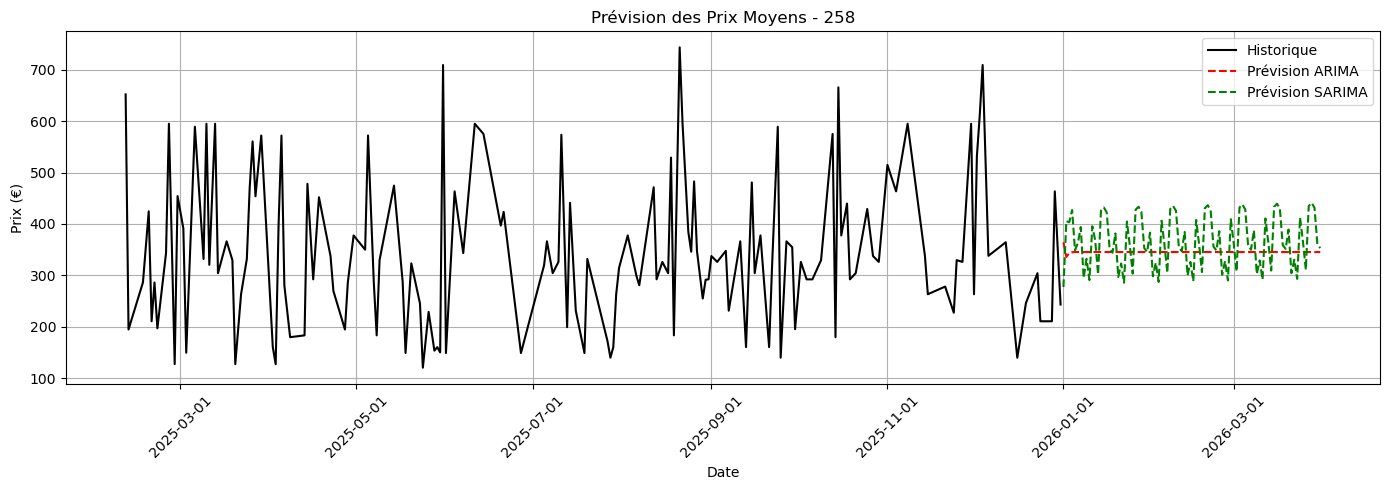


=== 3. SCORES DE PERFORMANCE ===
📌 ARIMA ➤ MAE: 105.34 | RMSE: 139.35
📌 SARIMA ➤ MAE: 114.40 | RMSE: 145.72


In [66]:
# Chargement et exécution
ts_data, main_dest = price_time_series(hotels)
forecast_models(ts_data, main_dest)


In [75]:
pip install --upgrade pip setuptools wheel


  Using cached setuptools-78.1.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 1.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.8 MB 1.8 MB/s eta 0:00:01
   ---------------------------- ----------- 1.3/1.8 MB 1.8 MB/s eta 0:00:01
   ---------------------------------- ----- 1.6/1.8 MB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 1.9 MB/s eta 0:00:00
Using cached setuptools-78.1.0-py3-none-any.whl (1.3 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.44.0
    Uninstalling wheel-0.44.0:
      Successfully uninstalled wheel-0.44.0
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.1.0
    Un

In [81]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     --- ------------------------------------ 0.5/6.2 MB 2.8 MB/s eta 0:00:03
     ----- ---------------------------------- 0.8/6.2 MB 2.4 MB/s eta 0:00:03
     ---------- ----------------------------- 1.6/6.2 MB 2.5 MB/s eta 0:00:02
     ------------- -------------------------- 2.1/6.2 MB 2.6 MB/s eta 0:00:02
     ---------------- ----------------------- 2.6/6.2 MB 2.6 MB/s eta 0:00:02
     -------------------- ------------------- 3.1/6.2 MB 2.6 MB/s eta 0:00:02
     ------------------------- -------------- 3.9/6.2 MB 2.8 MB/s eta 0:00:01
     --------------------------- ------------ 4.2/6.2 MB 2.6 MB/s eta 0:00:01
     ---------------------------- ----------- 4.5/6.2 MB 2.6 MB/s eta 0:00:01
     ------------------------------ --------- 4.7/6.2 MB 2.4 MB/s eta 0:00:01
     --------------------------------- ------ 5.2/6.2 MB 2.3 MB/s eta 0:00:01
     ---------

In [91]:
def recommander_hotels_par_lieu(hotels_df, location_id, top_n=5):
    sous_ensemble = hotels_df[hotels_df['FK_Location'] == location_id]
    meilleurs_hotels = sous_ensemble.sort_values(by='New_Price').head(top_n)
    return meilleurs_hotels[['Hotel_Name', 'New_Price', 'Number_of_Stars']]


In [89]:
print("Colonnes disponibles :", hotels.columns.tolist())


Colonnes disponibles : ['Fk_Hotels', 'FK_Hotel_desc', 'FK_CheckinDate', 'FK_CheckoutDate', 'FK_Location', 'Hotel_Name', 'Number_of_Stars', 'Old_Price', 'New_Price', 'Travel_Agency', 'KMeans_Cluster', 'DBSCAN_Cluster', 'Agglomerative_Cluster']


In [93]:
recommander_hotels_par_lieu(hotels, location_id=258)


,Hotel_Name,New_Price,Number_of_Stars
73558,Ambassadeurs Hotel,116.542999,3.0
69193,LE CALIFE,120.172997,2.0
67736,Ambassadeurs Hotel,127.138000,3.0
66794,Ambassadeurs Hotel,127.138000,3.0
69381,Ambassadeurs Hotel,127.138000,3.0


In [101]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

def recommander_hotels_similaires(hotels_df, hotel_name, top_n=5):
    hotels_filtered = hotels_df.dropna(subset=['New_Price', 'Number_of_Stars']).reset_index(drop=True)
    features = hotels_filtered[['New_Price', 'Number_of_Stars']]
    
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)

    sim_matrix = cosine_similarity(scaled)

    try:
        index = hotels_filtered[hotels_filtered['Hotel_Name'] == hotel_name].index[0]
    except IndexError:
        print(f"❌ Hôtel '{hotel_name}' non trouvé dans la base.")
        return pd.DataFrame()

    scores = list(enumerate(sim_matrix[index]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    indices_recos = [i for i, score in scores[1:top_n+1]]
    return hotels_filtered.iloc[indices_recos][['Hotel_Name', 'New_Price', 'Number_of_Stars']]


In [103]:
recommander_hotels_similaires(hotels, hotel_name="LE CALIFE")


,Hotel_Name,New_Price,Number_of_Stars
762,Private Room in Shared Apartment in the Center...,52.000000,1.0
573,Generator Madrid,54.000000,1.0
58,Hilton London Olympia,140.000000,2.0
107,Tribu MalasaÃ±a,140.000000,2.0
73,Hôtel Al Karmel,139.628998,2.0


In [72]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim


def ncf_recommender(hotels_df, epochs=20, embedding_size=32):
    print("\n=== 6. Neural Collaborative Filtering (NCF) ===")

    hotels_df = hotels_df.dropna(subset=['Fk_Hotels', 'FK_Location', 'New_Price']).copy()
    hotels_df['User_ID'] = hotels_df.groupby('FK_Location').ngroup()

    # Encodage
    le_user = LabelEncoder()
    le_hotel = LabelEncoder()

    hotels_df['User_ID_enc'] = le_user.fit_transform(hotels_df['User_ID'])
    hotels_df['Hotel_ID_enc'] = le_hotel.fit_transform(hotels_df['Fk_Hotels'])

    num_users = hotels_df['User_ID_enc'].nunique()
    num_hotels = hotels_df['Hotel_ID_enc'].nunique()

    X = hotels_df[['User_ID_enc', 'Hotel_ID_enc']].values
    y = hotels_df['New_Price'].values

    # Normalisation des prix
    scaler = StandardScaler()
    y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

    # Tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.long)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # === Modèle ===
    class NCF(nn.Module):
        def __init__(self, n_users, n_items, embed_dim):
            super().__init__()
            self.user_embed = nn.Embedding(n_users, embed_dim)
            self.item_embed = nn.Embedding(n_items, embed_dim)
            self.fc1 = nn.Linear(embed_dim * 2, 64)
            self.dropout = nn.Dropout(0.3)
            self.fc2 = nn.Linear(64, 1)

        def forward(self, x):
            u = self.user_embed(x[:, 0])
            i = self.item_embed(x[:, 1])
            x = torch.cat([u, i], dim=1)
            x = torch.relu(self.fc1(x))
            x = self.dropout(x)
            return self.fc2(x)

    model = NCF(num_users, num_hotels, embedding_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train_tensor)
        loss = criterion(preds, y_train_tensor)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    # === Évaluation ===
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy().flatten()
        y_true = y_test_tensor.numpy().flatten()
        mae = mean_absolute_error(y_true, predictions)
        rmse = np.sqrt(mean_squared_error(y_true, predictions))
        print(f"\n📊 MAE (scaled): {mae:.2f} | RMSE (scaled): {rmse:.2f}")

    print("\n✅ Modèle NCF entraîné avec succès !")
    return model, le_user, le_hotel, scaler


In [75]:
model, le_user, le_hotel, scaler = ncf_recommender(hotels)



=== 6. Neural Collaborative Filtering (NCF) ===
Epoch 1/20 - Loss: 1.0261
Epoch 2/20 - Loss: 1.0058
Epoch 3/20 - Loss: 0.9792
Epoch 4/20 - Loss: 0.9801
Epoch 5/20 - Loss: 0.9699
Epoch 6/20 - Loss: 0.9383
Epoch 7/20 - Loss: 0.9390
Epoch 8/20 - Loss: 0.9244
Epoch 9/20 - Loss: 0.9050
Epoch 10/20 - Loss: 0.8859
Epoch 11/20 - Loss: 0.8896
Epoch 12/20 - Loss: 0.8804
Epoch 13/20 - Loss: 0.8575
Epoch 14/20 - Loss: 0.8407
Epoch 15/20 - Loss: 0.8530
Epoch 16/20 - Loss: 0.8325
Epoch 17/20 - Loss: 0.8017
Epoch 18/20 - Loss: 0.7958
Epoch 19/20 - Loss: 0.7984
Epoch 20/20 - Loss: 0.7951

📊 MAE (scaled): 0.69 | RMSE (scaled): 0.88

✅ Modèle NCF entraîné avec succès !


In [77]:
def recommander_hotels_ncf(model, le_user, le_hotel, hotels_df, user_location_id, scaler, top_n=5):
    model.eval()
    hotels_df = hotels_df.dropna(subset=['FK_Location', 'Fk_Hotels', 'New_Price']).copy()
    hotels_df['User_ID'] = hotels_df.groupby('FK_Location').ngroup()

    try:
        user_id_simulé = hotels_df[hotels_df['FK_Location'] == user_location_id].iloc[0]['User_ID']
    except IndexError:
        print(f"❌ Aucune localisation avec ID {user_location_id} trouvée.")
        return pd.DataFrame()

    user_enc = le_user.transform([user_id_simulé])[0]
    hotel_ids = hotels_df['Fk_Hotels'].unique()
    hotel_encs = le_hotel.transform(hotel_ids)

    user_tensor = torch.tensor([[user_enc, h] for h in hotel_encs], dtype=torch.long)

    with torch.no_grad():
        predicted_scaled = model(user_tensor).numpy().flatten()
        predicted_prices = scaler.inverse_transform(predicted_scaled.reshape(-1, 1)).flatten()

    results = pd.DataFrame({
        'Fk_Hotels': hotel_ids,
        'Predicted_Price': predicted_prices
    })

    merged = pd.merge(results, hotels_df[['Fk_Hotels', 'Hotel_Name', 'Number_of_Stars']], on='Fk_Hotels', how='left')
    merged = merged.drop_duplicates('Fk_Hotels')
    merged = merged.sort_values(by='Predicted_Price')

    return merged[['Hotel_Name', 'Number_of_Stars', 'Predicted_Price']].head(top_n)


In [81]:
recommander_hotels_ncf(model, le_user, le_hotel, hotels, user_location_id=258, scaler=scaler)


,Hotel_Name,Number_of_Stars,Predicted_Price
595,Hotel Edward Paddington,2.0,204.444458
986,HÃ´tel Club Val d'Anfa Casablanca Ocean view,6.0,222.855026
410,Ambassadeurs Hotel,3.0,223.757599
970,ADAY Hotel Casablanca,5.0,234.781357
549,HÃ´tel Plaza AthÃ©nÃ©e - Dorchester Collection,1.0,236.225967
